## Task 8
When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

**Strategy:**
- determine what is a short, medium and long flight 
    - ""American Airlines defines: 
        - short-/medium-haul flights as being less than 3,000 mi (2,600 nmi; 4,800 km) 
        - long-haul as either being more than 3,000 mi (2,600 nmi; 4,800 km) 
    - United Airlines defines: 
        - short-haul flights as being less than 700 mi (610 nmi; 1,100 km) 
        - long-haul flights as being greater than 3,000 mi (2,600 nmi; 4,800 km)"" [(link)](https://en.wikipedia.org/wiki/Flight_length)
  
        - short < 700 mi
        - 700 mi <= medium < 3000 mi
        - long >= 3000 mi
- For our purposes our 75% is only 999 miles this means we predominently don't deal with long haul flights: 
- bin the flights into 0,1,2 for short, medium and long  determine which hour has the most of each type of flight length

---
**INPUT** : flights nulls removed

---

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("flight_sample_small.csv")

In [92]:
df = pd.read_csv("flight_sample_large.csv")

In [109]:
df.distance.describe()

count    5.000000e+06
mean     7.674067e+02
std      5.853547e+02
min      1.600000e+01
25%      3.380000e+02
50%      6.030000e+02
75%      9.990000e+02
max      5.095000e+03
Name: distance, dtype: float64

In [5]:
df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime'],
      dtype='object')

In [6]:
def define_haul_length(distance):
    """Determine the haul length of a given distance
    INPUT distance (in miles)
    RETURNS {0: short haul, 1: medium haul, 2: long haul}"""
    
    if distance < 700:
        return 0 
    elif distance < 3000:
        return 1
    else: 
        return 2

In [12]:
def check_time_block(time):
    """Determine the hour of the day
    INPUT time HHMM
    RETURNS hour 0-23 where 0 == 12am and 23 == 11pm"""
    if type(time) == 'numpy.ndarray':
        time = time.astype(int)
    time = int(time)
    
    t = time // 100
    if t == 0:
        return 0
    return t-1

**Expectations** 
- I would anticipate seeing long hauls leaving in the morning and arriving at night and the medium and short interspersed throughout

*Looking first at departures*

In [93]:
taskeight_dep = df[['crs_dep_time', 'dep_time','distance']]

In [94]:
#convert the HHMM to an hour bin 
taskeight_dep["crs_dep_time"] = taskeight_dep["crs_dep_time"].map(check_time_block)
taskeight_dep["dep_time"] = taskeight_dep["dep_time"].map(check_time_block)
#convert the distance to a haul length
taskeight_dep["distance"] = taskeight_dep["distance"].map(define_haul_length)

In [95]:
#create dummies for the haul length
dummies = pd.get_dummies(taskeight_dep.distance)
dummies.rename(columns = {0: "short_haul", 1: "medium_haul", 2:"long_haul"}, inplace=True)
taskeight_dep = taskeight_dep.merge(dummies, right_index=True, left_index=True)
taskeight_dep.drop("distance",axis=1, inplace=True)

In [96]:
# create a df grouped by hour -- for both crs and actual dep time
taskeight_depcrs = taskeight_dep.groupby("crs_dep_time", as_index=False)[["short_haul", "medium_haul", "long_haul"]].sum()
taskeight_depact = taskeight_dep.groupby("dep_time", as_index=False)[["short_haul", "medium_haul", "long_haul"]].sum()

Text(0.5, 0.98, 'Haul Frequency by CRS Departure Hour')

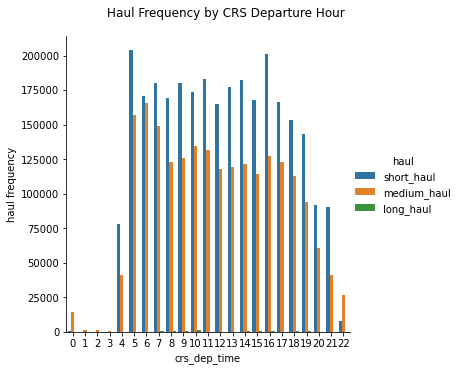

In [97]:
taskeight_depcrs = pd.melt(taskeight_depcrs, id_vars="crs_dep_time", var_name="haul", value_name="haul frequency")
g = sns.factorplot(x='crs_dep_time', y='haul frequency', hue='haul', data=taskeight_depcrs, kind='bar')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Haul Frequency by CRS Departure Hour')

Text(0.5, 0.98, 'Haul Length Frequency by Actual Departure Hour')

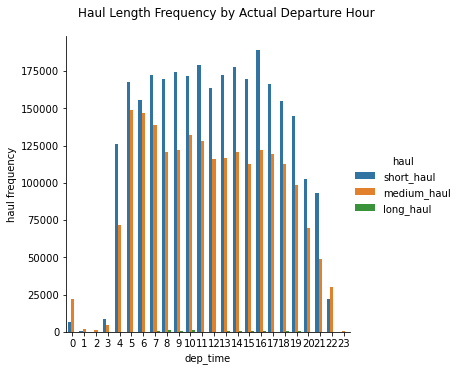

In [98]:
taskeight_depact = pd.melt(taskeight_depact, id_vars="dep_time", var_name="haul", value_name="haul frequency")
g = sns.factorplot(x='dep_time', y='haul frequency', hue='haul', data=taskeight_depact, kind='bar')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Haul Length Frequency by Actual Departure Hour')

*Looking at arrivals*

In [99]:
taskeight_arr = df[['crs_arr_time', 'arr_time','distance']]

In [100]:
#convert the HHMM to an hour bin 
taskeight_arr["crs_arr_time"] = taskeight_arr["crs_arr_time"].map(check_time_block)
taskeight_arr["arr_time"] = taskeight_arr["arr_time"].map(check_time_block)
#convert the distance to a haul length
taskeight_arr["distance"] = taskeight_arr["distance"].map(define_haul_length)

In [101]:
#create dummies for the haul length
dummies = pd.get_dummies(taskeight_arr.distance)
dummies.rename(columns = {0: "short_haul", 1: "medium_haul", 2:"long_haul"}, inplace=True)
taskeight_arr = taskeight_arr.merge(dummies, right_index=True, left_index=True)
taskeight_arr.drop("distance",axis=1, inplace=True)

In [102]:
#create a df grouped by hour -- for both crs and actual dep time
taskeight_arrcrs = taskeight_arr.groupby("crs_arr_time", as_index=False)[["short_haul", "medium_haul", "long_haul"]].sum()
taskeight_arract = taskeight_arr.groupby("arr_time", as_index=False)[["short_haul", "medium_haul", "long_haul"]].sum()

Text(0.5, 0.98, 'Haul Length Frequency by CRS Arrival Hour')

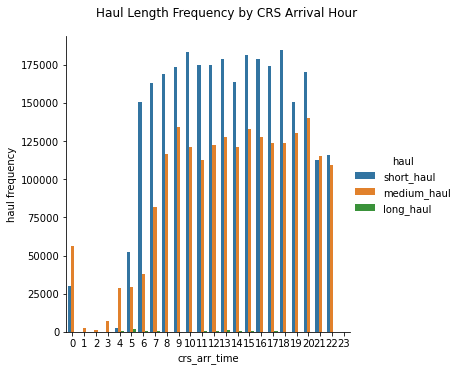

In [103]:
taskeight_arrcrs = pd.melt(taskeight_arrcrs, id_vars="crs_arr_time", var_name="haul", value_name="haul frequency")
g = sns.factorplot(x='crs_arr_time', y='haul frequency', hue='haul', data=taskeight_arrcrs, kind='bar')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Haul Length Frequency by CRS Arrival Hour')

Text(0.5, 0.98, 'Haul Length Frequency by Actual Arrival Hour')

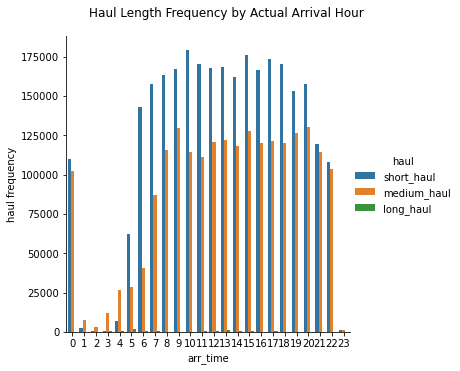

In [104]:
taskeight_arract = pd.melt(taskeight_arract, id_vars="arr_time", var_name="haul", value_name="haul frequency")
g = sns.factorplot(x='arr_time', y='haul frequency', hue='haul', data=taskeight_arract, kind='bar')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Haul Length Frequency by Actual Arrival Hour')

**Summarize General Frequencies of Flight Types**

In [105]:
hauls = taskeight_arract.groupby("haul")['haul frequency'].sum()

In [107]:
print("there are: ", len(df), " flights")
print("there are: ", hauls['long_haul'],  " long haul flights")
print("there are: ", hauls['medium_haul'],  " medium haul flights")
print("there are: ", hauls['short_haul'],  " short haul flights")

there are:  5000000  flights
there are:  7682.0  long haul flights
there are:  2105445.0  medium haul flights
there are:  2886873.0  short haul flights


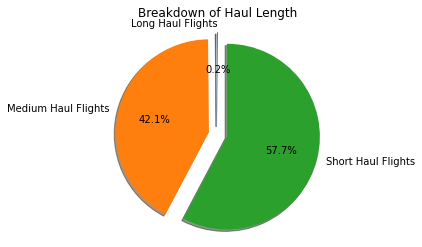

In [108]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Long Haul Flights', 'Medium Haul Flights', 'Short Haul Flights'
sizes = [hauls['long_haul'], hauls['medium_haul'],hauls['short_haul']]
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Breakdown of Haul Length')
plt.show()

In [110]:
taskeight_dep = df[['crs_dep_time', 'dep_time','distance']]
#convert the HHMM to an hour bin 
taskeight_dep["crs_dep_time"] = taskeight_dep["crs_dep_time"].map(check_time_block)
taskeight_dep["dep_time"] = taskeight_dep["dep_time"].map(check_time_block)
#convert the distance to a haul length
taskeight_dep["distance"] = taskeight_dep["distance"].map(define_haul_length)
#create dummies for the haul length
dummies = pd.get_dummies(taskeight_dep.distance)
dummies.rename(columns = {0: "short_haul", 1: "medium_haul", 2:"long_haul"}, inplace=True)
taskeight_dep = taskeight_dep.merge(dummies, right_index=True, left_index=True)
taskeight_dep.drop("distance",axis=1, inplace=True)

In [112]:
taskeight_dep.to_csv("taskeight_dep.csv", index=False)